# Enrichment for genes DE between neighbouring stages
Genes whose expression changes strongly between two neighbouring stages were selected with two different methods (described below). These methods also ensure that genes do not change between many neighbouring stages.

In [26]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from networks.functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for results
pathImpulse='/home/karin/Documents/timeTrajectories/data/stages/DE_across_stages/'
pathDeseq='/home/karin/Documents/timeTrajectories/data/deTime/neighbouring/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [3]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 495
N sets {('GO', 'molecular_function'): 35, ('GO', 'cellular_component'): 24, ('Dictybase', 'Phenotypes'): 209, ('Custom', 'Baylor'): 13, ('GO', 'biological_process'): 52, ('KEGG', 'Pathways'): 96}


In [4]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

## Enrichment report

In [37]:
#Result filtering
MAX_FDR_DE=0.01
MIN_ABS_LFC_DE=2
MAX_N_SIGNIFICANT_DE=2
#Enrichment
PADJ=0.25
MIN_OVERLAP=2
MAX_FE_BAR=40
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#000000',"#171082", "#6d00b0",'#a1239f', "#b0003e",'#b01a00','#cc6300','#eb9202','#d4a600','#e3dc12']

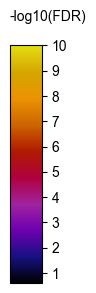

In [6]:
#Colour fold change legend
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)

In [46]:
# Load data
data_deseq=pd.read_table(pathDeseq+'combined.tsv',index_col=0)
data_impulse=pd.read_table(pathImpulse+'DEacrossStages_summary_mainstage_WT_0.001.tsv',index_col=0)
data=pd.concat([data_deseq,data_impulse],sort=True,axis=1)

In [42]:
#Extracts comparisons form DESeq2 results. Assumes that the same are present in Impulse
COMPARISONS=[comparison.replace('_FDR_overall','') for comparison in data.columns[data.columns.str.contains('_FDR_overall')]]

In [47]:
#Count N significant comparisons
for gene in data.index:
    data_gene = data.loc[gene, :]
    significant = 0
    for comparison in COMPARISONS:
        # Stages were compared
        if data_gene.index.str.contains(comparison).any():
            if abs(data_gene[comparison + '_log2FoldChange']) >= MIN_ABS_LFC_DE and data_gene[
                comparison + '_FDR_overall'] <= MAX_FDR_DE:
                significant += 1
    data.loc[gene, 'Significant_N'] = significant


### Filtering by restricting N of DE neighbouring stages
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) Gene is not DE according to the above criteria in more than 2 neighbouring stages.

***  no_agg_stream selected: 952 with EID: 946
Ratio of genes annotated with a gene set in reference 0.38 and query 0.39
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 219 out of 373 query genes used for enrichment calculation.


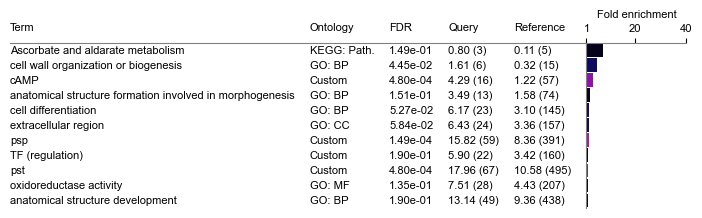

***  stream_lag selected: 68 with EID: 68
Ratio of genes annotated with a gene set in reference 0.38 and query 0.46
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 23 out of 31 query genes used for enrichment calculation.


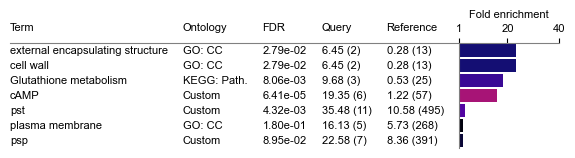

***  lag_tag selected: 609 with EID: 609
Ratio of genes annotated with a gene set in reference 0.38 and query 0.53
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 258 out of 324 query genes used for enrichment calculation.


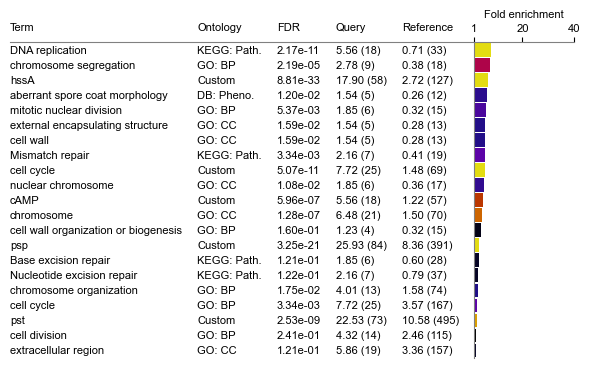

***  tag_tip selected: 148 with EID: 147
Ratio of genes annotated with a gene set in reference 0.38 and query 0.54
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 63 out of 80 query genes used for enrichment calculation.


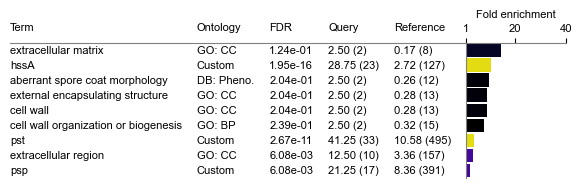

***  tip_slug selected: 59 with EID: 59
Ratio of genes annotated with a gene set in reference 0.38 and query 0.64
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 38 query genes used for enrichment calculation.


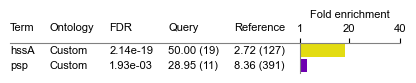

***  slug_mhat selected: 405 with EID: 400
Ratio of genes annotated with a gene set in reference 0.38 and query 0.4
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 79 out of 158 query genes used for enrichment calculation.


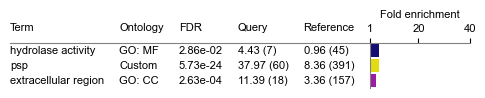

***  mhat_cul selected: 166 with EID: 164
Ratio of genes annotated with a gene set in reference 0.38 and query 0.32
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 52 query genes used for enrichment calculation.


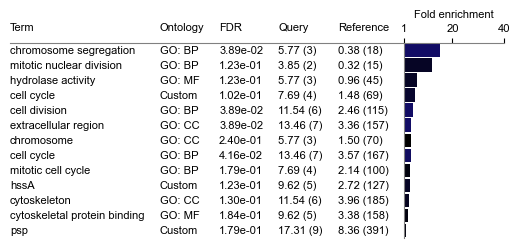

***  cul_FB selected: 132 with EID: 132
Ratio of genes annotated with a gene set in reference 0.38 and query 0.33
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 43 query genes used for enrichment calculation.


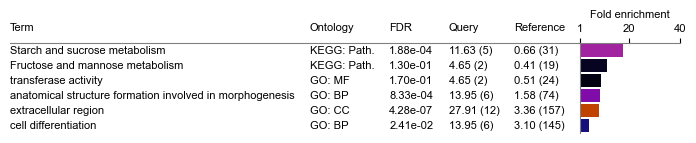

In [44]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(MIN_ABS_LFC_DE) +
                      ' & ' + comparison + '_FDR_overall <=' + str(MAX_FDR_DE) +
                      '& Significant_N <=' + str(MAX_N_SIGNIFICANT_DE)).index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

### Filtering by using stages identified as transitions by ImpulseDE2
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) ImpulseDE2 identified gene as DE expressed through stages and the transition occured between the two neighbouring stages.

***  no_agg_stream selected: 581 with EID: 576
Ratio of genes annotated with a gene set in reference 0.38 and query 0.39
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 73 out of 225 query genes used for enrichment calculation.


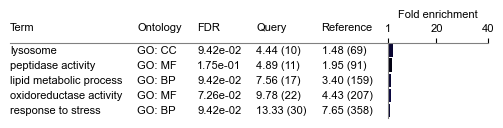

***  stream_lag selected: 27 with EID: 27
Ratio of genes annotated with a gene set in reference 0.38 and query 0.37
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 4 out of 10 query genes used for enrichment calculation.


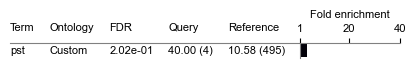

***  lag_tag selected: 303 with EID: 303
Ratio of genes annotated with a gene set in reference 0.38 and query 0.47
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 116 out of 143 query genes used for enrichment calculation.


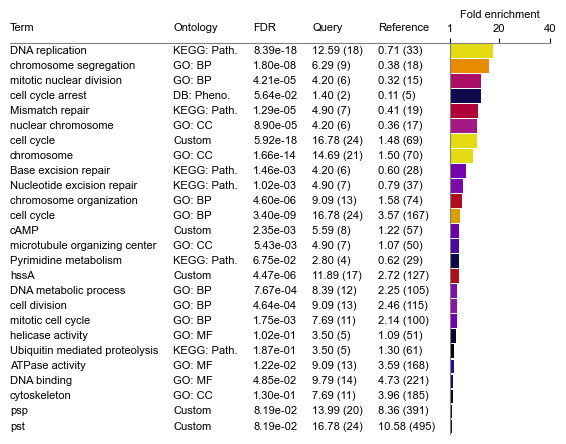

***  tag_tip selected: 61 with EID: 61
Ratio of genes annotated with a gene set in reference 0.38 and query 0.51
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 19 out of 31 query genes used for enrichment calculation.


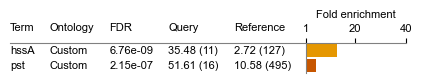

***  tip_slug selected: 12 with EID: 12
Ratio of genes annotated with a gene set in reference 0.38 and query 1.0
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 12 query genes used for enrichment calculation.


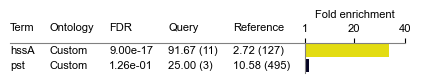

***  slug_mhat selected: 168 with EID: 167
Ratio of genes annotated with a gene set in reference 0.38 and query 0.44
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 37 out of 73 query genes used for enrichment calculation.


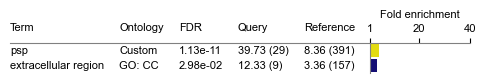

***  mhat_cul selected: 114 with EID: 112
Ratio of genes annotated with a gene set in reference 0.38 and query 0.32
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 36 query genes used for enrichment calculation.


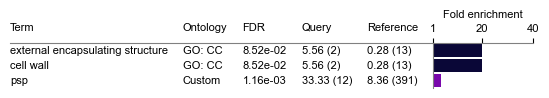

***  cul_FB selected: 133 with EID: 133
Ratio of genes annotated with a gene set in reference 0.38 and query 0.29
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 16 out of 38 query genes used for enrichment calculation.


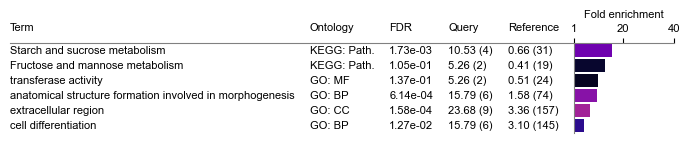

In [48]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(MIN_ABS_LFC_DE) +
                      ' & ' + comparison + '_FDR_overall <=' + str(MAX_FDR_DE) +
                      '& ' + comparison + ' == 1').index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    